<a href="https://colab.research.google.com/github/warlords94/personal-coding/blob/main/MNIST_CAM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import scipy as sp

In [2]:
# load the Fashion MNIST dataset
(X_train,Y_train),(X_test,Y_test)  = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
# Put an additional axis for the channels of the image.
# Fashion MNIST is grayscale so we place 1 at the end. Other datasets
# will need 3 if it's in RGB.
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# Normalize the pixel values from 0 to 1
X_train = X_train/255
X_test  = X_test/255

# Cast to float
X_train = X_train.astype('float')
X_test  = X_test.astype('float')

In [4]:
def show_img(img):
    '''utility function for reshaping and displaying an image'''

    # convert to float array if img is not yet preprocessed
    img  = np.array(img,dtype='float')

    # remove channel dimension
    img = img.reshape((28,28))

    # display image
    plt.imshow(img)

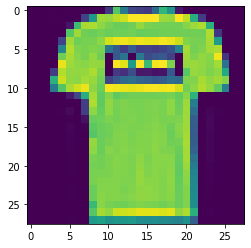

In [5]:
# test the function for the first train image. you can vary the index of X_train
# below to see other images

show_img(X_train[1])

In [6]:
# use the Sequential API
model = Sequential()

# notice the padding parameter to recover the lost border pixels when doing the convolution
model.add(Conv2D(16,input_shape=(28,28,1),kernel_size=(3,3),activation='relu',padding='same'))
# pooling layer with a stride of 2 will reduce the image dimensions by half
model.add(MaxPooling2D(pool_size=(2,2)))

# pass through more convolutions with increasing filters
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))

# use global average pooling to take into account lesser intensity pixels
model.add(GlobalAveragePooling2D())

# output class probabilities
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [7]:
# configure the training
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

# train the model. just run a few epochs for this test run. you can adjust later.
model.fit(X_train,Y_train,batch_size=32, epochs=5, validation_split=0.1, shuffle=True)

Epoch 1/5
1688/1688 [==============================] - 63s 37ms/step - loss: 0.6046 - accuracy: 0.7751 - val_loss: 0.4110 - val_accuracy: 0.8522
Epoch 2/5
1688/1688 [==============================] - 67s 40ms/step - loss: 0.3756 - accuracy: 0.8613 - val_loss: 0.3519 - val_accuracy: 0.8715
Epoch 3/5
1688/1688 [==============================] - 60s 36ms/step - loss: 0.3195 - accuracy: 0.8821 - val_loss: 0.3052 - val_accuracy: 0.8858
Epoch 4/5
1688/1688 [==============================] - 61s 36ms/step - loss: 0.2827 - accuracy: 0.8962 - val_loss: 0.3024 - val_accuracy: 0.8857
Epoch 5/5
1688/1688 [==============================] - 59s 35ms/step - loss: 0.2556 - accuracy: 0.9068 - val_loss: 0.2722 - val_accuracy: 0.9018


In [8]:
# final convolution layer
print(model.layers[-3].name)

# global average pooling layer
print(model.layers[-2].name)

# output of the classifier
print(model.layers[-1].name)

conv2d_3
global_average_pooling2d
dense


In [10]:
# same as previous model but with an additional output
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

In [11]:
# get the features and results of the test images using the newly created model
features,results = cam_model.predict(X_test)

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

features shape:  (10000, 3, 3, 128)
results shape (10000, 10)


In [12]:
last_dense_layer = model.layers[-1]
gap_weights_l = last_dense_layer.get_weights()
print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains biases  (10,)
There are 128 feature weights and 10 classes.


In [14]:
idx =0
features_for_img = features[idx,:,:,:]
print(f"The features for image index {idx} has shape (height, width, num of feature channels) : ", features_for_img.shape)

The features for image index 0 has shape (height, width, num of feature channels) :  (3, 3, 128)


In [15]:
features_for_img_scaled = sp.ndimage.zoom(features_for_img ,(28/3,28/3,1) ,order =2 )
print("features_for_img_scaled up to 28 by 28 height and width:", features_for_img_scaled.shape)

features_for_img_scaled up to 28 by 28 height and width: (28, 28, 128)


In [18]:
class_id =0
gap_weights_for_one_class = gap_weights[:,class_id]
print("features_for_img_scaled has shape ", features_for_img_scaled.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
cam = np.dot(features_for_img_scaled ,gap_weights_for_one_class)
print("class activation map shape ", cam.shape)

features_for_img_scaled has shape  (28, 28, 128)
gap_weights_for_one_class has shape  (128,)
class activation map shape  (28, 28)


In [ ]:
# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for 
gap_weights_for_one_class = gap_weights[:,class_id]

print("features_for_img_scaled has shape ", features_for_img_scaled.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img_scaled, gap_weights_for_one_class)

print("class activation map shape ", cam.shape)

In [19]:
def show_cam(image_index):
  features_for_img = features[image_index,:,:,:]
  prediction = np.argmax(results[image_index])
  class_activation_weights = gap_weights[:,prediction]
  class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)
  cam_output = np.dot(class_activation_features,class_activation_weights)
  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))
  plt.imshow(np.squeeze(X_test[image_index],-1), alpha=0.5)
  
  # strongly classified (95% probability) images will be in green, else red
  if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # overlay the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

In [20]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

please choose a class less than 10
Predicted Class = 7, Probability = 0.9999796


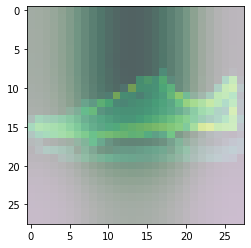

Predicted Class = 7, Probability = 0.9999107


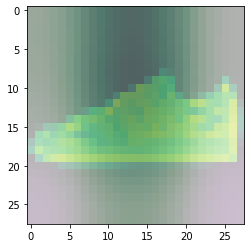

Predicted Class = 7, Probability = 0.99999535


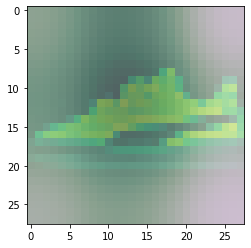

Predicted Class = 7, Probability = 0.9999118


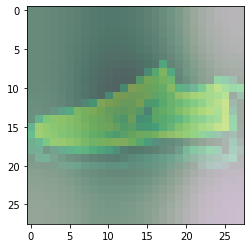

Predicted Class = 7, Probability = 0.947628


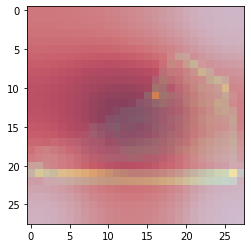

Predicted Class = 7, Probability = 0.9998436


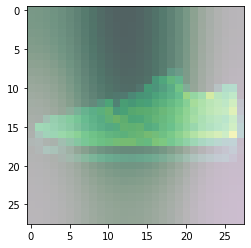

Predicted Class = 7, Probability = 0.98309326


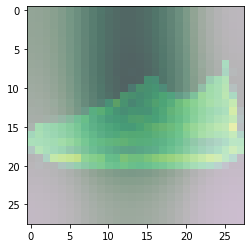

Predicted Class = 7, Probability = 0.9737941


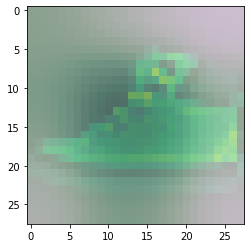

Predicted Class = 7, Probability = 0.9998301


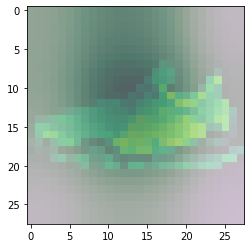

Predicted Class = 7, Probability = 0.99979943


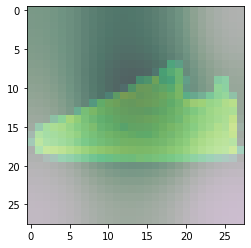

Predicted Class = 7, Probability = 0.99991596


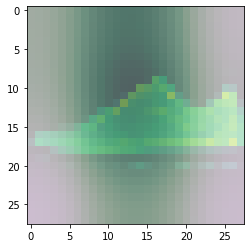

Predicted Class = 7, Probability = 0.9997707


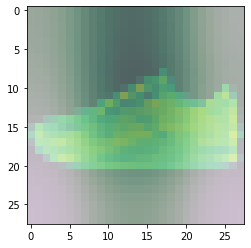

Predicted Class = 7, Probability = 0.90320086


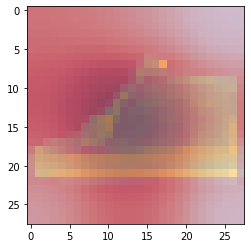

Predicted Class = 7, Probability = 0.99990916


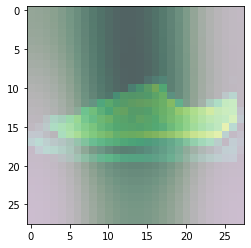

Predicted Class = 7, Probability = 0.9948501


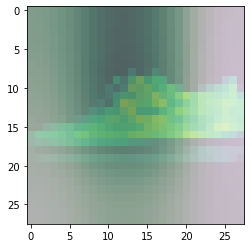

Predicted Class = 7, Probability = 0.99861157


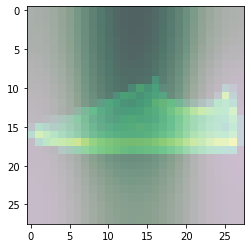

Predicted Class = 7, Probability = 0.99959093


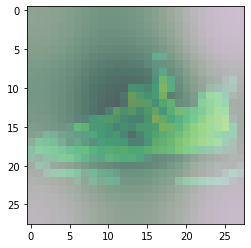

Predicted Class = 7, Probability = 0.97735786


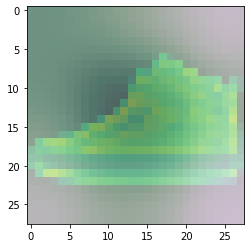

Predicted Class = 7, Probability = 0.99994147


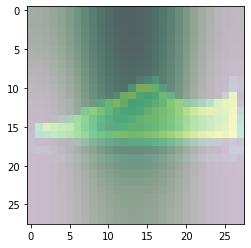

Predicted Class = 7, Probability = 0.9999213


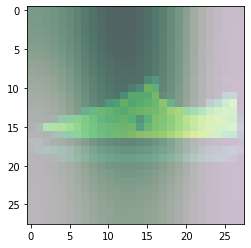

In [21]:
show_maps(desired_class=7, num_maps=20)